In [66]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
import seaborn as sns
from cvxopt import matrix, solvers
from copy import copy
from scipy import stats

In [20]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
selected_assets = [
'NVDA', 'ISRG', 'APO', 'COST', 'CAT', 'MPC', 'SHW', 'NRG', 'NFLX',
'CBRE', 'SI=F'
]
existing_assets = [c for c in selected_assets if c in data.columns]
data = data[existing_assets]
print(f"Assets found in file: {len(existing_assets)} / {len(selected_assets)}")
data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')

pnl = np.log(data_clean / data_clean.shift(1)).dropna()

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

Assets found in file: 11 / 11
Returns: 2470 days × 11 assets
Date range: 2016-01-05 → 2025-11-11


In [21]:
instrument_names = pnl.columns.tolist()
means = pnl.mean().values
covariance_matrix = pnl.cov().values

vols = np.sqrt(np.diag(covariance_matrix))
correlation_matrix = np.diag(vols**-1) @ covariance_matrix @ np.diag(vols**-1)

In [22]:
I = len(instrument_names)
G = -np.eye(I)
h = np.zeros(I)
mv_opt = ft.MeanVariance(means, covariance_matrix, G, h)

In [23]:
B = 1000  # Number of efficient frontiers
P = 9  # Number of portfolios used to span the efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(3)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [24]:
# Base frontier with no parameter uncertainty
frontier = mv_opt.efficient_frontier(P)
results = np.full((P, 2), np.nan)
results[:, 0] = means @ frontier
for p in range(P):
    results[p, 1] = frontier[:, p] @ covariance_matrix @ frontier[:, p]

## Analysis of Parameter Uncertainty

Mean, Variance, and Correlation importance.

In [38]:
# Mean Uncertainty
solvers.options['show_progress'] = False  

frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)

failed = 0
for b in range(B):
    try:
        means_run = np.mean(return_sim[:, b, :], axis=0)
        mv_opt._expected_return_row = -matrix(means_run).T
        frontier_mean[:, :, b] = mv_opt.efficient_frontier(P)
        mean_results[:, 0, b] = means @ frontier_mean[:, :, b]
        for p in range(P):
            mean_results[p, 1, b] = frontier_mean[:, p, b] @ covariance_matrix @ frontier_mean[:, p, b]
    except:
        failed += 1
        continue

mv_opt._expected_return_row = -matrix(means).T  # Reset means

print(f"Mean uncertainty frontiers computed: {B - failed}/{B} succeeded")
if failed > 0:
    print(f"  ({failed} bootstraps failed due to numerical issues)")

Mean uncertainty frontiers computed: 979/1000 succeeded
  (21 bootstraps failed due to numerical issues)


In [39]:
# Volatility Uncertainty
frontier_vol = np.full((I, P, B), np.nan)
vol_results = np.full((P, 2, B), np.nan)

failed = 0
for b in range(B):
    try:
        vols_run = np.diag(np.std(return_sim[:, b, :], axis=0))
        cov_matrix_run = vols_run @ correlation_matrix @ vols_run
        mv_opt._P = matrix(1000 * cov_matrix_run)
        frontier_vol[:, :, b] = mv_opt.efficient_frontier(P)
        vol_results[:, 0, b] = means @ frontier_vol[:, :, b]
        for p in range(P):
            vol_results[p, 1, b] = frontier_vol[:, p, b] @ covariance_matrix @ frontier_vol[:, p, b]
    except:
        failed += 1
        continue

mv_opt._P = matrix(1000 * covariance_matrix)  # Reset covariance

print(f"Vol uncertainty frontiers computed: {B - failed}/{B} succeeded")
if failed > 0:
    print(f"  ({failed} bootstraps failed due to numerical issues)")

Vol uncertainty frontiers computed: 1000/1000 succeeded


In [40]:
# Correlation Uncertainty
frontier_cor = np.full((I, P, B), np.nan)
cor_results = np.full((P, 2, B), np.nan)

failed = 0
for b in range(B):
    try:
        cor_matrix_run = ft.correlation_matrix(return_sim[:, b, :]).values
        cov_matrix_run = np.diag(vols) @ cor_matrix_run @ np.diag(vols)
        mv_opt._P = matrix(1000 * cov_matrix_run)
        frontier_cor[:, :, b] = mv_opt.efficient_frontier(P)
        cor_results[:, 0, b] = means @ frontier_cor[:, :, b]
        for p in range(P):
            cor_results[p, 1, b] = frontier_cor[:, p, b] @ covariance_matrix @ frontier_cor[:, p, b]
    except:
        failed += 1
        continue

mv_opt._P = matrix(1000 * covariance_matrix)  

print(f"Correlation uncertainty frontiers computed: {B - failed}/{B} succeeded")
if failed > 0:
    print(f"  ({failed} bootstraps failed due to numerical issues)")

Correlation uncertainty frontiers computed: 1000/1000 succeeded


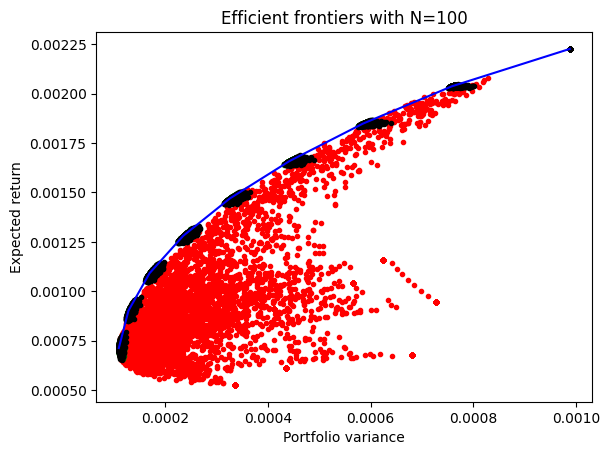

In [93]:
plt.plot(mean_results[:, 1, :], mean_results[:, 0, :], 'r.')
plt.plot(vol_results[:, 1, :], vol_results[:, 0, :], 'g.')
plt.plot(cor_results[:, 1, :], cor_results[:, 0, :], 'k.')
plt.plot(results[:, 1], results[:, 0], 'b-')
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio variance')
plt.show()

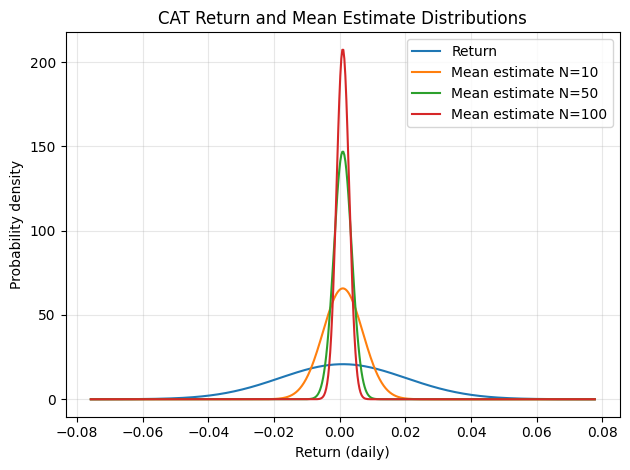

In [47]:
asset_idx = 0  # CAT in your universe
asset_name = instrument_names[asset_idx]

x_min = means[asset_idx] - 4 * vols[asset_idx]
x_max = means[asset_idx] + 4 * vols[asset_idx]
x = np.linspace(x_min, x_max, 500)

plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx]))
plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx] / np.sqrt(10)))
plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx] / np.sqrt(50)))
plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx] / np.sqrt(100)))
plt.legend(['Return', 'Mean estimate N=10', 'Mean estimate N=50', 'Mean estimate N=100'])
plt.title(f'{asset_name} Return and Mean Estimate Distributions')
plt.ylabel('Probability density')
plt.xlabel('Return (daily)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Resampling
Vorobets: Sample convergence. He uses the traditional resampling approach on the middle portfolio to investigate how many samples are needed before the resulting exposures start to converge.

In [48]:
pf_index = 4

In [49]:
# Efficient frontier without resampling
np.round(frontier[:, pf_index] * 100, 1)

array([43.2,  0. ,  0. , 22.9, 12.6,  0. ,  0. , 15.4,  0. ,  0. ,  6. ])

In [54]:
track_idx = [0, 3, 4, 7, 9]  # NVDA, COST, CAT, NRG, CBRE
track_names = [instrument_names[i] for i in track_idx]

exposure_re_vals = np.full((len(track_idx), B), np.nan)

for b in range(B):
    re_pf = np.nanmean(frontier_mean[:, pf_index, 0:b+1], axis=1)
    exposure_re_vals[:, b] = re_pf[track_idx]

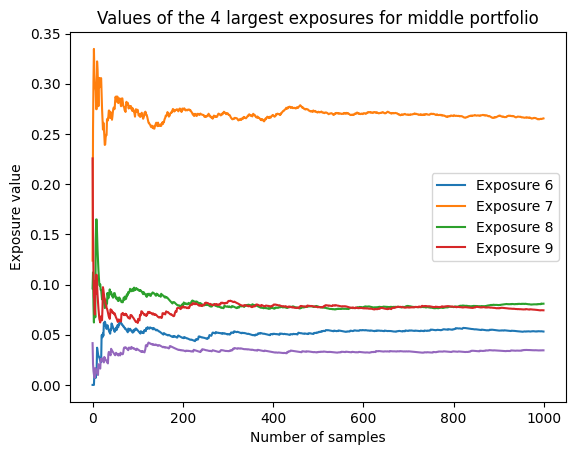

In [55]:
plt.plot(exposure_re_vals.T)
plt.legend(['Exposure 6', 'Exposure 7', 'Exposure 8', 'Exposure 9'])
plt.xlabel('Number of samples')
plt.ylabel('Exposure value')
plt.title('Values of the 4 largest exposures for middle portfolio')
plt.show()

## Exposure Stacking

In [58]:
solvers.options['show_progress'] = False

def exposure_stacking(L, frontier, num_samples):
    """Computes the L-fold Exposure Stacking.
    
    Partitions the first num_samples samples from the frontier into L sets 
    of equal size and computes the L-fold Exposure Stacking.
    
    Args:
        L: Number of partition sets.
        frontier: Resampled exposures frontier with shape (I, P, B).
        num_samples: Number of samples to include.
    
    Returns:
        Exposure Stacking portfolio.    
    """
    partition_size = num_samples // L
    M = frontier[:, pf_index, :num_samples].T
    P = np.zeros((num_samples, num_samples))
    q = np.zeros((num_samples, 1))
    
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q = q + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    
    P = matrix(2 * partition_size * P)
    q = matrix(-2 * q)
    
    # Weights must sum to one
    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))
    
    # Weights must be nonnegative
    G = matrix(-np.identity(num_samples))
    h = matrix(np.zeros((num_samples, 1)))
    
    sol = solvers.qp(P, q, G, h, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    
    return exposure

In [59]:
valid_mask = ~np.isnan(frontier_mean[0, pf_index, :])
num_valid = valid_mask.sum()
frontier_clean = frontier_mean[:, :, valid_mask]

print(f"Valid bootstraps: {num_valid}/{B}")

num_samples = num_valid
exposure_2 = exposure_stacking(2, frontier_clean, num_samples)
exposure_5 = exposure_stacking(5, frontier_clean, num_samples)
exposure_B = exposure_stacking(num_valid, frontier_clean, num_samples)

print(f"\nExposure Stacking Results (Portfolio {pf_index}):\n")
print(f"{'Asset':<8} {'L=2':>8} {'L=5':>8} {'L=B':>8}")
print("-" * 35)
for i, name in enumerate(instrument_names):
    print(f"{name:<8} {exposure_2[i]*100:>7.1f}% {exposure_5[i]*100:>7.1f}% {exposure_B[i]*100:>7.1f}%")

Valid bootstraps: 979/1000

Exposure Stacking Results (Portfolio 4):

Asset         L=2      L=5      L=B
-----------------------------------
NVDA         6.4%     5.8%     5.3%
ISRG         3.9%     3.8%     4.1%
APO          3.1%     3.5%     3.5%
COST        26.2%    26.5%    26.5%
CAT          7.0%     7.7%     8.1%
MPC          4.8%     4.7%     4.9%
SHW          9.9%    10.1%    10.5%
NRG          8.8%     7.6%     7.4%
NFLX         7.2%     6.4%     6.1%
CBRE         2.5%     2.9%     3.4%
SI=F        20.2%    20.8%    20.1%


In [60]:
# Out-of-sample simulations
return_sim_oos = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [61]:
def risk_return(pf):
    """Computes the out of sample risk and return of the portfolio.

    Args:
        pf: Portfolio to measure risk and return against.

    Returns:
        Array of shape (2, B) with risk and return for each of the B simulations.
    """
    risk_return = np.full((2, B), np.nan)
    for b in range(B):
        means_run = np.mean(return_sim_oos[:, b, :], axis=0)
        cov_run = np.cov(return_sim_oos[:, b, :], rowvar=False)
        risk_return[0, b] = pf @ cov_run @ pf
        risk_return[1, b] = means_run @ pf
    return risk_return

In [62]:
re_rr = risk_return(re_pf)
re_rar = re_rr[1, :] / re_rr[0, :]
frontier_rr = risk_return(frontier[:, pf_index])
frontier_rar = frontier_rr[1, :] / frontier_rr[0, :]
es_2_rr = risk_return(exposure_2)
es_2_rar = es_2_rr[1, :] / es_2_rr[0, :]
es_5_rr = risk_return(exposure_5)
es_5_rar = es_5_rr[1, :] / es_5_rr[0, :]
es_B_rr = risk_return(exposure_B)
es_B_rar = es_B_rr[1, :] / es_B_rr[0, :]

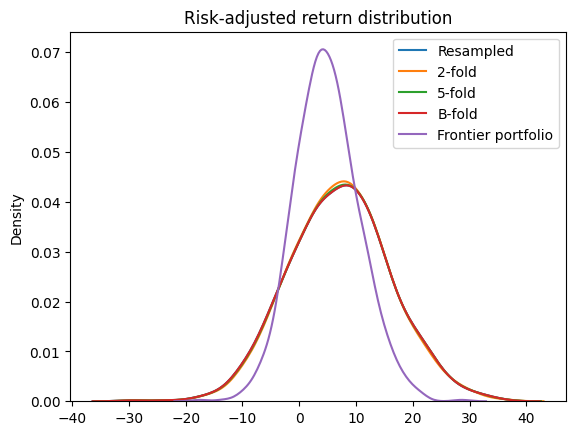

In [68]:
sns.kdeplot(x=re_rar)
sns.kdeplot(x=es_2_rar)
sns.kdeplot(x=es_5_rar)
sns.kdeplot(x=es_B_rar)
sns.kdeplot(x=frontier_rar)
plt.title('Risk-adjusted return distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()

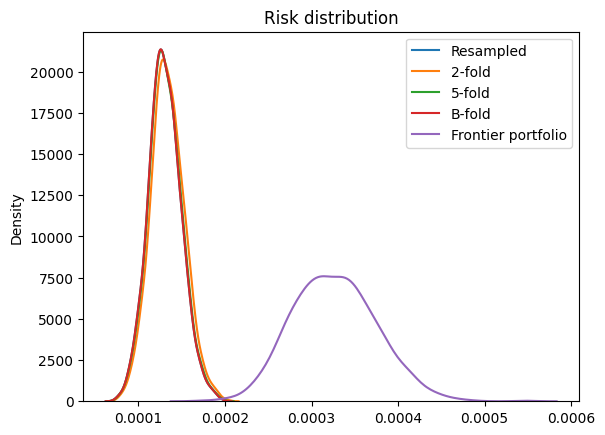

In [69]:
sns.kdeplot(x=re_rr[0, :])
sns.kdeplot(x=es_2_rr[0, :])
sns.kdeplot(x=es_5_rr[0, :])
sns.kdeplot(x=es_B_rr[0, :])
sns.kdeplot(x=frontier_rr[0, :])
plt.title('Risk distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()

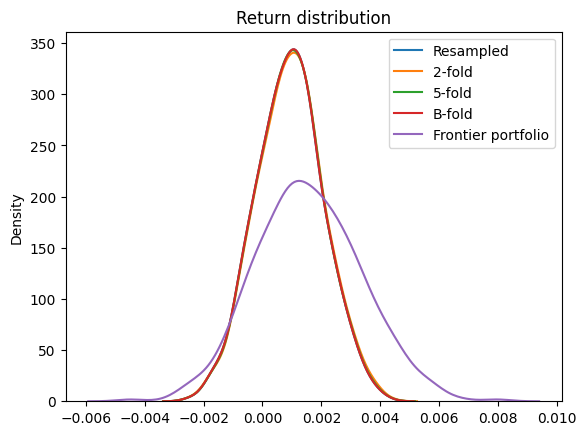

In [70]:
sns.kdeplot(x=re_rr[1, :])
sns.kdeplot(x=es_2_rr[1, :])
sns.kdeplot(x=es_5_rr[1, :])
sns.kdeplot(x=es_B_rr[1, :])
sns.kdeplot(x=frontier_rr[1, :])
plt.title('Return distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()


In [84]:
summary_stats = pd.DataFrame({
    'Method': ['Base Frontier', 'Resampled', 'ES L=2', 'ES L=5', 'ES L=B'],
    'Mean Return': [
        np.nanmean(frontier_rr[1, :]) * 100,
        np.nanmean(re_rr[1, :]) * 100,
        np.nanmean(es_2_rr[1, :]) * 100,
        np.nanmean(es_5_rr[1, :]) * 100,
        np.nanmean(es_B_rr[1, :]) * 100
    ],
    'Mean Risk': [
        np.nanmean(frontier_rr[0, :]) * 100,
        np.nanmean(re_rr[0, :]) * 100,
        np.nanmean(es_2_rr[0, :]) * 100,
        np.nanmean(es_5_rr[0, :]) * 100,
        np.nanmean(es_B_rr[0, :]) * 100
    ],
    'Annlzd Mean Return': [
        np.nanmean(frontier_rr[1, :]) * 100 * 252,
        np.nanmean(re_rr[1, :]) * 100 * 252,
        np.nanmean(es_2_rr[1, :]) * 100 * 252,
        np.nanmean(es_5_rr[1, :]) * 100 * 252,
        np.nanmean(es_B_rr[1, :]) * 100 * 252
    ],
    'Annlzd Mean Risk': [
        np.nanmean(frontier_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(re_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(es_2_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(es_5_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(es_B_rr[0, :]) * 10000 * np.sqrt(252)
    ],
    'Sharpe': [
        (np.nanmean(frontier_rr[1, :]) * 100 * 252) / (np.nanmean(frontier_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(re_rr[1, :]) * 100 * 252) / (np.nanmean(re_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(es_2_rr[1, :]) * 100 * 252) / (np.nanmean(es_2_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(es_5_rr[1, :]) * 100 * 252) / (np.nanmean(es_5_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(es_B_rr[1, :]) * 100 * 252) / (np.nanmean(es_B_rr[0, :]) * 10000 * np.sqrt(252))
    ]
})

summary_stats = summary_stats.set_index('Method')
print("Out-of-Sample Performance Summary:\n")
print(summary_stats.round(4))

Out-of-Sample Performance Summary:

               Mean Return  Mean Risk  Annlzd Mean Return  Annlzd Mean Risk  \
Method                                                                        
Base Frontier       0.1565     0.0327             39.4344           51.8862   
Resampled           0.0914     0.0131             23.0421           20.7207   
ES L=2              0.0940     0.0134             23.6950           21.2331   
ES L=5              0.0922     0.0131             23.2310           20.8034   
ES L=B              0.0914     0.0130             23.0348           20.7136   

               Sharpe  
Method                 
Base Frontier  0.7600  
Resampled      1.1120  
ES L=2         1.1159  
ES L=5         1.1167  
ES L=B         1.1121  
